In [195]:
# Website Categorization: End-to-End Machine Learning Pipeline
# This notebook demonstrates a complete ML pipeline for categorizing websites based on their content, following the requirements outlined in the problem overview.
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split



import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix







# etc.# from mlab.ensemble import RandomForestClassifier# from mlab.naive_bayes import NaiveBayesClassifier# If you want to use your own mlab library, import it herefrom sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import re

In [196]:
df = pd.read_parquet('train.parquet')
df.dtypes

domain      object
url         object
html        object
markdown    object
dtype: object

In [197]:
df.head()

,domain,url,html,markdown
0,Wildlife Conservation in Africa,https://www.zimparks.org.zw/wp-content/uploads...,%PDF-1.7\r\n%����\r\n1 0 obj\r\n&lt;&gt;/Metad...,%PDF-1.7\n%����\n1 0 obj\n<>/Metadata 2607 0 R...
1,Blockchain for Financial Services,https://www.capco.com/intelligence/capco-intel...,\n<!DOCTYPE html>\n\n<html>\n<head>\n<!-- OneT...,Search\nSuggested keywords\nX\n# Tokenization ...
2,Antarctic Expeditions,https://www.expeditions.com/destinations/antar...,"<!DOCTYPE html>\n<html lang=""en""><head><meta c...",* DestinationsRegions\n Featured Destinations...
3,Taxation Laws in the EU,https://hadea.ec.europa.eu/news/mapping-tax-po...,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"" p...",Select your languageClose\nSearchSearch\nEurop...
4,Genetic Engineering Advances,https://pubmed.ncbi.nlm.nih.gov/35587330/,"<!DOCTYPE html>\n\n<html lang=""en"">\n<head ite...","Clipboard, Search History, and several other a..."


In [198]:
df.isna().sum()

domain      0
url         0
html        0
markdown    0
dtype: int64

In [199]:
class TextPreprocessor:
    def __init__(self):
        # Load stopwords, initialize vocab, etc.
        self.vocab = {}
        
    def fit(self, X):
        # Build vocabulary from X['markdown'] text
        pass
    
    def transform(self, X):
        # Clean, tokenize, vectorize, return feature matrix
        pass
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

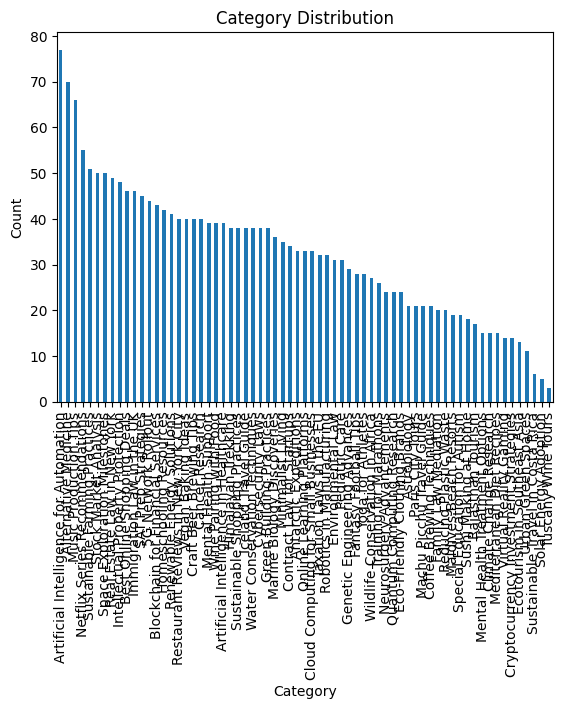

In [200]:
df['domain'].value_counts().plot(kind='bar', title='Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [201]:
df['text_length'] = df['markdown'].str.len()
df['word_count'] = df['markdown'].str.split().apply(len)

# Cool new features:
df['avg_word_length'] = df['markdown'].apply(lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 0 else 0)
df['num_sentences'] = df['markdown'].apply(lambda x: str(x).count('.') + str(x).count('!') + str(x).count('?'))
df['num_exclamations'] = df['markdown'].apply(lambda x: str(x).count('!'))
df['num_questions'] = df['markdown'].apply(lambda x: str(x).count('?'))
df['num_uppercase_words'] = df['markdown'].apply(lambda x: sum(1 for w in str(x).split() if w.isupper()))
df['num_digits'] = df['markdown'].apply(lambda x: sum(c.isdigit() for c in str(x)))
df['num_unique_words'] = df['markdown'].apply(lambda x: len(set(str(x).split())))
df['unique_word_ratio'] = df['num_unique_words'] / (df['word_count'] + 1e-6)  # avoid division by zero

# Show summary statistics for all features
df[['text_length', 'word_count', 'avg_word_length', 'num_sentences', 'num_exclamations', 
    'num_questions', 'num_uppercase_words', 'num_digits', 'num_unique_words', 'unique_word_ratio']].describe()
# ...existing code...
df[['text_length', 'word_count']].describe()

,text_length,word_count
count,2176.000000,2176.000000
mean,9713.527114,1508.401195
std,16422.359048,2614.630674
min,0.000000,0.000000
25%,2341.500000,367.000000
50%,6425.500000,1002.000000
75%,11862.000000,1862.250000
max,468694.000000,77040.000000


In [202]:
value = df[df['domain'] == 'Astrobiology']

value['markdown'].head()


54     Main Menu\n \n* Menu Toggle\n* Menu Toggle\n* ...
280    # Graduate Program\nThe UW Astrobiology Progra...
334    Search\n \n Close\n Menu\n Menu\n Search\n \n ...
392    * Explore\nSearch\n* News & Events\n* Multimed...
612    Notice: This is an archived and unmaintained p...
Name: markdown, dtype: object

In [203]:
print('Number of duplicate rows:', df.duplicated().sum())

Number of duplicate rows: 0


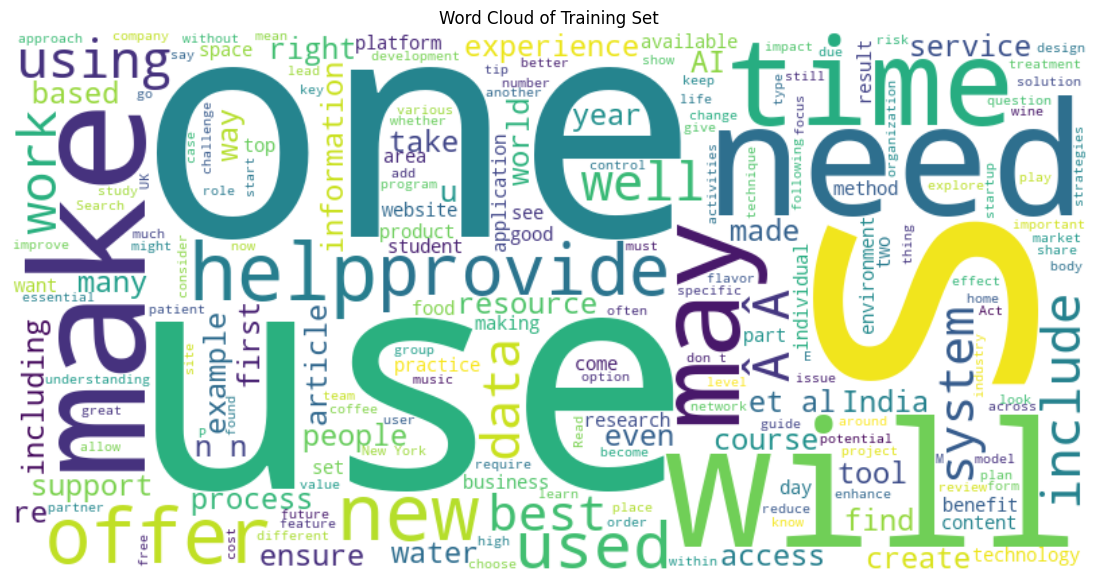

In [204]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all markdown text into one string
text = " ".join(df['markdown'].astype(str).tolist())

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Training Set')
plt.show()

In [205]:
import sys, os
# Add parent directory to path for imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from mlab.common.utils import oversample_minority

In [206]:
def oversample_minority(X, y, random_state=42):
    np.random.seed(random_state)
    unique, counts = np.unique(y, return_counts=True)

    max_count = counts.max()
    print(f"Maximum class count: {max_count}")
    Xy_balanced = []
    for label in unique:
        X_class = X[y == label]
        n_samples = X_class.shape[0]
        if n_samples < max_count:
            # Randomly sample with replacement
            idxs = np.random.choice(n_samples, size=max_count, replace=True)
            X_upsampled = X_class[idxs]
        else:
            X_upsampled = X_class
        y_upsampled = np.full((max_count,), label)
        Xy_balanced.append((X_upsampled, y_upsampled))
    X_bal = np.vstack([x for x, _ in Xy_balanced])
    y_bal = np.concatenate([y for _, y in Xy_balanced])
    return X_bal, y_bal


In [207]:
class TextPreprocessor:
    def __init__(self):
        # Load stopwords, initialize vocab, etc.
        self.vocab = {}
        self.stopwords = set(['the', 'and', 'is', 'in', 'to', 'of', 'a', 'for', 'on', 'with', 'as', 'by', 'at', 'from', 'thing'])
    
    def clean_text(self, text):
        # Lowercase, remove non-alphabetic, remove stopwords
        text = text.lower()
        text = re.sub(r'[^a-z\s]', '', text)
        tokens = text.split()
        tokens = [t for t in tokens if t not in self.stopwords]
        return tokens
    
    def fit(self, X):
        # Build vocabulary from X['markdown'] text
        vocab = Counter()
        # oversample minority classes if needed
        if 'domain' in X.columns:
            X = oversample_minority(X, X['domain'])
            
        for doc in X['markdown']:
            tokens = self.clean_text(doc)
            vocab.update(tokens)
        self.vocab = {word: idx for idx, (word, _) in enumerate(vocab.most_common(1000))}
    
    def transform(self, X):
        # Vectorize text using bag-of-words
        features = np.zeros((len(X), len(self.vocab)), dtype=int)
        for i, doc in enumerate(X['markdown']):
            tokens = self.clean_text(doc)
            for t in tokens:
                idx = self.vocab.get(t)
                if idx is not None:
                    features[i, idx] += 1
        return features
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [208]:
df.columns

Index(['domain', 'url', 'html', 'markdown', 'text_length', 'word_count',
       'avg_word_length', 'num_sentences', 'num_exclamations', 'num_questions',
       'num_uppercase_words', 'num_digits', 'num_unique_words',
       'unique_word_ratio'],
      dtype='object')

In [209]:
def oversample_minority(X, y, random_state=42):
    np.random.seed(random_state)
    unique, counts = np.unique(y, return_counts=True)
    max_count = counts.max()
    
    Xy_balanced = []
    for label in unique:
        X_class = X[y == label]
        n_samples = X_class.shape[0]
        if n_samples < max_count:
            idxs = np.random.choice(n_samples, size=max_count, replace=True)
            X_upsampled = X_class.iloc[idxs]
        else:
            X_upsampled = X_class
        y_upsampled = np.full((max_count,), label)
        Xy_balanced.append((X_upsampled, y_upsampled))
    
    X_bal = pd.concat([x for x, _ in Xy_balanced], axis=0).reset_index(drop=True)
    y_bal = np.concatenate([y for _, y in Xy_balanced])
    y_bal = pd.DataFrame(y_bal, columns=['domain'])
    return X_bal, y_bal


In [210]:
X_bal, yP_bal = oversample_minority(df, df['domain'])


In [211]:
X_bal

,domain,url,html,markdown,text_length,word_count,avg_word_length,num_sentences,num_exclamations,num_questions,num_uppercase_words,num_digits,num_unique_words,unique_word_ratio
0,5G Network Rollout,https://www.linkedin.com/pulse/environmental-i...,"<!DOCTYPE html>\n\n<html class=""cls-fix-enable...",Agree & Join LinkedIn\nBy clicking Continue to...,11534,1587,6.205419,77,0,0,26,38,754,0.475110
1,5G Network Rollout,https://wraycastle.com/blogs/glossary/what-is-...,"<!DOCTYPE html>\n\n<html class=""no-js"" lang=""e...",Search\nSite navigation\nSearch\nSearch\nMenu\...,3684,543,5.731123,26,0,1,18,47,318,0.585635
2,5G Network Rollout,https://www.ookla.com/articles/plan-optimize-m...,"\n<!DOCTYPE html>\n\n<html class=""html-page-la...",* + ## Join Ookla at Mobile World Congress Bar...,8154,1319,5.003033,53,0,0,88,100,517,0.391964
3,5G Network Rollout,https://www.civilsdaily.com/5g-rollout-in-indi...,"<!DOCTYPE html>\n\n<html lang=""en-US"" prefix=""...",No. 1 UPSC IAS Platform for preparation\nMenu ...,8718,1417,5.131969,55,1,2,57,101,682,0.481299
4,5G Network Rollout,https://www.blare.tech/post/the-challenge-of-5...,<!DOCTYPE html>\n<!-- Last Published: Mon Mar ...,# The challenge of 5G network planning\nFebrua...,10206,1271,7.030685,99,5,8,57,128,781,0.614477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5154,Yoga for Athletes,https://yogatrinity.com/yoga-injuries-rates-ri...,"<!DOCTYPE html>\n\n<html lang=""en-US"">\n<head>...",Stay Connected :\n \n✕\n* ▼\n + ▼\n* ▼\n* ▼\n...,20504,3499,4.834810,197,4,30,27,76,1311,0.374678
5155,Yoga for Athletes,https://www.yogajournal.com/practice/yoga-for-...,"\n<!DOCTYPE html>\n\n<html lang=""en-US"">\n<hea...",Powered by **Outside**\n* Be one of the first ...,5157,818,5.293399,46,2,7,1,24,452,0.552567
5156,Yoga for Athletes,https://bodybyyoga.training/yoga-for-athletes/...,"<!DOCTYPE html>\n\n<html lang=""en-US"" prefix=""...",* #### \n \n \n \n \n \n \n #### \n \n...,8992,1526,4.792923,105,3,11,16,117,631,0.413499
5157,Yoga for Athletes,https://skill-yoga.blog/yoga-for-balance/,"<!DOCTYPE html>\n\n<html class=""no-js scheme_d...",# Yoga for Balance: 15 Yoga Poses for Balance ...,14731,2761,4.327780,68,8,6,3,8,770,0.278884


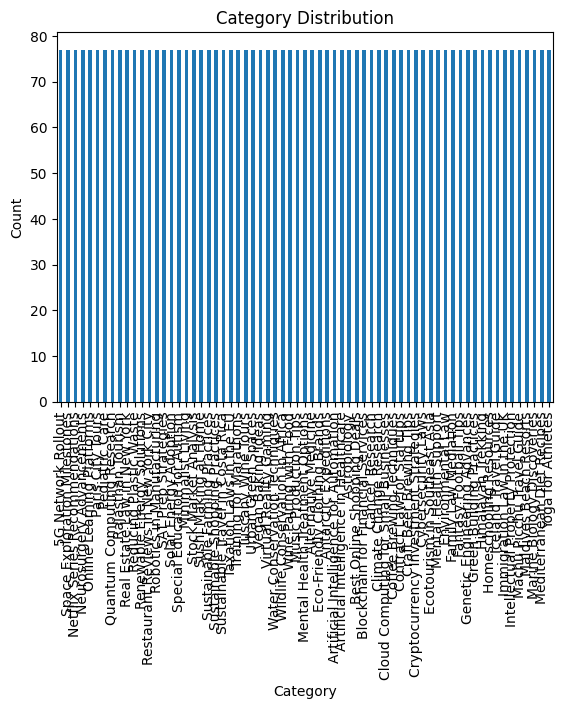

In [212]:
X_bal['domain'].value_counts().plot(kind='bar', title='Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [213]:
# check most common words in the balanced dataset
from collections import Counter
def get_most_common_words(X, n=20):
    all_words = []
    for doc in X['markdown']:
        tokens = re.findall(r'\b\w+\b', doc.lower())
        all_words.extend(tokens)
    return Counter(all_words).most_common(n)
most_common_words = get_most_common_words(X_bal, n=20)
print("Most common words in balanced dataset:")
for word, count in most_common_words:
    print(f"{word}: {count}")


Most common words in balanced dataset:
the: 310151
and: 249856
of: 187414
to: 182497
a: 150743
in: 129239
for: 95143
is: 76216
with: 61253
you: 57318
that: 51034
on: 48457
s: 46547
are: 43453
it: 41696
your: 41611
as: 41149
or: 39627
this: 39034
can: 37629


In [241]:
import re
import numpy as np
from collections import Counter

class TextPreprocessor:
    def __init__(self, text_columns=None):
        # text_columns: list of columns to preprocess (default: ['markdown'])
        self.text_columns = text_columns if text_columns is not None else ['markdown']
        self.vocab = {}
        self.stopwords = set(['the', 'and', 'is', 'in', 'to', 'of', 'a', 'for', 'on', 'with', 'as', 'by', 'at', 'from', 'thing'])

    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'[^a-z\s]', '', text)
        tokens = text.split()
        tokens = [t for t in tokens if t not in self.stopwords]
        return tokens

    def fit(self, X):
        vocab = Counter()
        if 'domain' in X.columns:
            X, y = oversample_minority(X, X['domain'])
        for col in self.text_columns:
            for doc in X[col].astype(str):
                tokens = self.clean_text(doc)
                vocab.update(tokens)
        self.vocab = {word: idx for idx, (word, _) in enumerate(vocab.most_common(1000))}

    def transform(self, X):
        features = np.zeros((len(X), len(self.vocab)), dtype=int)
        for i, row in X.iterrows():
            for col in self.text_columns:
                tokens = self.clean_text(str(row[col]))
                for t in tokens:
                    idx = self.vocab.get(t)
                    if idx is not None:
                        features[i, idx] += 1
        return features

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [ ]:
class FeatureExtractor:
    def __init__(self, text_columns=None):
        self.da

    def fit(self, X):
        self.preprocessor.fit(X)

    def transform(self, X):
        return self.preprocessor.transform(X)

    def fit_transform(self, X):
        return self.preprocessor.fit_transform(X)

In [ ]:
class Preprocessor:
    def __init__(self, text_columns=None):
        self.text_preprocessor = TextPreprocessor(text_columns=text_columns)
    
    def feature_engineering(self, X):
        # Add custom features
        X['text_length'] = X['markdown'].str.len()
        X['word_count'] = X['markdown'].str.split().apply(len)
        X['avg_word_length'] = X['markdown'].apply(lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 0 else 0)
        X['num_sentences'] = X['markdown'].apply(lambda x: str(x).count('.') + str(x).count('!') + str(x).count('?'))
        X['num_exclamations'] = X['markdown'].apply(lambda x: str(x).count('!'))
        X['num_questions'] = X['markdown'].apply(lambda x: str(x).count('?'))
        X['num_uppercase_words'] = X['markdown'].apply(lambda x: sum(1 for w in str(x).split() if w.isupper()))
        X['num_digits'] = X['markdown'].apply(lambda x: sum(c.isdigit() for c in str(x)))
        X['num_unique_words'] = X['markdown'].apply(lambda x: len(set(str(x).split())))
        X['unique_word_ratio'] = X['num_unique_words'] / (X['word_count'] + 1e-6)

    def fit(self, X):
        self.text_preprocessor.fit(X)

    def transform(self, X):

        return self.text_preprocessor.transform(X)

    def fit_transform(self, X):
        return self.text_preprocessor.fit_transform(X)

In [242]:
text_cols = ['markdown', 'html']  # Specify your text columns
preprocessor = TextPreprocessor(text_columns=text_cols)

X_features = preprocessor.fit_transform(df)
y = df['domain'].values

In [216]:
df.columns

Index(['domain', 'url', 'html', 'markdown', 'text_length', 'word_count',
       'avg_word_length', 'num_sentences', 'num_exclamations', 'num_questions',
       'num_uppercase_words', 'num_digits', 'num_unique_words',
       'unique_word_ratio'],
      dtype='object')

In [217]:
df.columns

Index(['domain', 'url', 'html', 'markdown', 'text_length', 'word_count',
       'avg_word_length', 'num_sentences', 'num_exclamations', 'num_questions',
       'num_uppercase_words', 'num_digits', 'num_unique_words',
       'unique_word_ratio'],
      dtype='object')

In [238]:
engineered_cols = [
    'text_length', 'word_count', 'avg_word_length', 'num_sentences',
    'num_exclamations', 'num_questions', 'num_uppercase_words',
    'num_digits', 'num_unique_words', 'unique_word_ratio'
]

In [239]:
engineered_features = df[engineered_cols].to_numpy()
X_features = np.concatenate([X_features, engineered_features], axis=1)

In [230]:
y

array(['Wildlife Conservation in Africa',
       'Blockchain for Financial Services', 'Antarctic Expeditions', ...,
       'Cybersecurity Laws', 'Antarctic Expeditions',
       'SAT Prep Strategies'], dtype=object)

In [240]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
from mlab.naive_bayes._naive_bayes import MultinomialNB  # Your mlab model
from mlab.ensemble._random_forest import RandomForestClassifier
# Assuming `X_features` is the output from your TextPreprocessor
# and `y` is the corresponding label array

# Combine features and labels for resampling
Xy = np.hstack([X_features, y.reshape(-1, 1)])

# Find the max class count for oversampling
unique, counts = np.unique(y, return_counts=True)
max_count = counts.max()



# Train your mlab model
clf = MultinomialNB()
clf.fit(X_features, y)

# --- Validation ---
# Load validation set
df_val = pd.read_parquet('validation.parquet')
X_val = preprocessor.transform(df_val)
y_val = df_val['domain'].values

# Predict and evaluate
y_pred = clf.predict(X_val)

print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1010 is different from 1000)

Text(0.5, 0, 'Category')

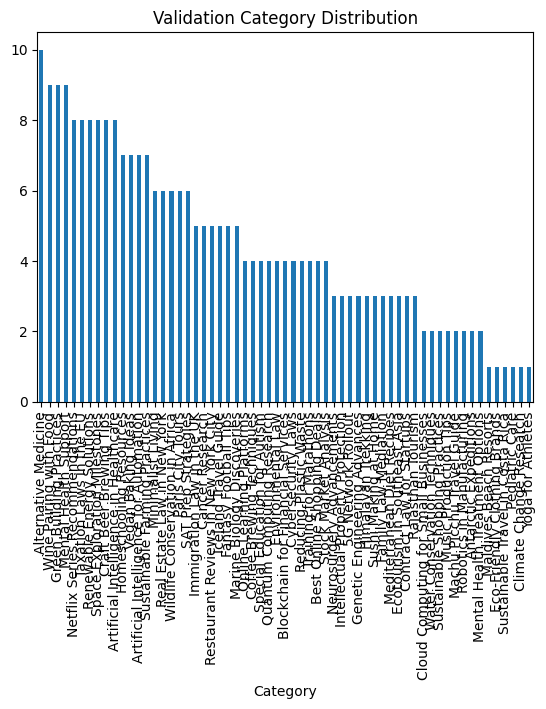

In [ ]:
df_val['domain'].value_counts().plot(kind='bar', title='Validation Category Distribution')
plt.xlabel('Category')  

# Summary
- Explored and analyzed the dataset
- Engineered features from text using a custom preprocessor
- Trained and evaluated a baseline classifier

You can further improve the pipeline by:
- Trying more advanced text representations (TF-IDF, word embeddings)
- Using your own mlab library classifiers
- Hyperparameter tuning and cross-validation
- Deeper error analysis and reporting


In [ ]:
# Analyze 'Astrobiology' samples in train and validation sets
astro_train = df[df['domain'] == 'Astrobiology']
astro_val = df_val[df_val['domain'] == 'Astrobiology']

print(f"Number of 'Astrobiology' samples in train: {len(astro_train)}")
print(f"Number of 'Astrobiology' samples in validation: {len(astro_val)}\n")

print("Sample training texts for 'Astrobiology':")
print(astro_train['markdown'].head(3).to_string(index=False))

print("\nSample validation texts for 'Astrobiology':")
print(astro_val['markdown'].head(3).to_string(index=False))

# Show most common words in Astrobiology training samples
from collections import Counter
words = ' '.join(astro_train['markdown'].astype(str)).split()
common_words = Counter(words).most_common(10)
print("\nMost common words in 'Astrobiology' training samples:")
print(common_words)

Number of 'Astrobiology' samples in train: 21
Number of 'Astrobiology' samples in validation: 0

Sample training texts for 'Astrobiology':
Main Menu\n \n* Menu Toggle\n* Menu Toggle\n* M...
# Graduate Program\nThe UW Astrobiology Program...
Search\n \n Close\n Menu\n Menu\n Search\n \n C...

Sample validation texts for 'Astrobiology':
Series([], )

Most common words in 'Astrobiology' training samples:
[('the', 522), ('and', 423), ('of', 396), ('|', 270), ('to', 259), ('in', 247), ('for', 157), ('a', 155), ('on', 109), ('is', 102)]


Bag-of-Words matrix shape: (2176, 1000)


AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names_out'